# **CSE440: Natural Language Processing II (LAB)**
---
## **Lab Assignment 02: Word Representation**  

---


### **Student Details**


In [1]:
ID = "22201604" # @param {"type":"string","placeholder":"Write your Student ID here"}
Name = "Priyankan Biswas" # @param {"type":"string","placeholder":"Write your full name here"}

### **Task 01 ||**

In [2]:
import pandas as pd
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

nltk.download('punkt')
nltk.download('stopwords')

dataset = pd.read_csv("IMDB Dataset.csv")
dataset['sentiment'] = dataset['sentiment'].replace({'positive': 1, 'negative': 0})
s=stopwords.words('english')
reviews = []
for r in dataset['review']:
    r = contractions.fix(r)
    t = regexp_tokenize(r, pattern=r'\d+\.\d+|\w+', gaps=False)
    new_tokens = []
    for word in t:
        if word.lower() not in s:
            new_tokens.append(word.lower())
    reviews.append(' '.join(new_tokens))

l = dataset['sentiment']

vectorizer = TfidfVectorizer(max_features=4000)
d_tfidf = vectorizer.fit_transform(reviews)

rev_train, rev_test, sent_train, sent_test = train_test_split(d_tfidf, l, test_size=0.2,stratify=l)
model = LogisticRegression(max_iter=500)
model.fit(rev_train, sent_train)
y_pred = model.predict(rev_test)
f1 = f1_score(sent_test, y_pred)
print(f"F1 Score: {f1:.5f}")




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\biswa\AppData\Local\Temp\ipykernel_24176\2932370853.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['sentiment'] = dataset['sentiment'].replace({'positive': 1, 'negative': 0})


F1 Score: 0.89229


### **Task 02 ||**

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import gensim
import numpy as np

def closest(v, m, e=None):    
    w = []
    embeddings = []
    for word in m.key_to_index:
        if word not in e: 
            w.append(word)
            embeddings.append(m[word])  

    embeddings = np.array(embeddings)
    cos_similarity = cosine_similarity([v], embeddings)[0]
    closest_word = np.argmax(cos_similarity)

    return w[closest_word], cos_similarity[closest_word]

f = "glove.840B.300d.txt" 
analogy_model = gensim.models.KeyedVectors.load_word2vec_format(f, binary=False, no_header=True)

vec = analogy_model["queen"] - analogy_model["female"] + analogy_model["male"]
closest_word, similarity = closest(vec, analogy_model, e={"queen", "female", "male"})
print(f"Closest word to the given analogy: {closest_word} (Similarity: {similarity:.4f})")
closest_word = analogy_model.most_similar(positive=["male", "queen"], negative=["female"], topn=1)
print(f"Closest word to 'Queen - Female + Male(using most_similar)': {closest_word}")







Closest word to the given analogy: king (Similarity: 0.7619)


C:\Users\biswa\AppData\Roaming\Python\Python312\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Closest word to 'Queen - Female + Male(using most_similar)': [('king', 0.7661396861076355)]


### **Task 03 ||**

Closest word to the given analogy: cried (Similarity: 0.8961)
Cosine similarity between 'king' and the analogy: 0.8805


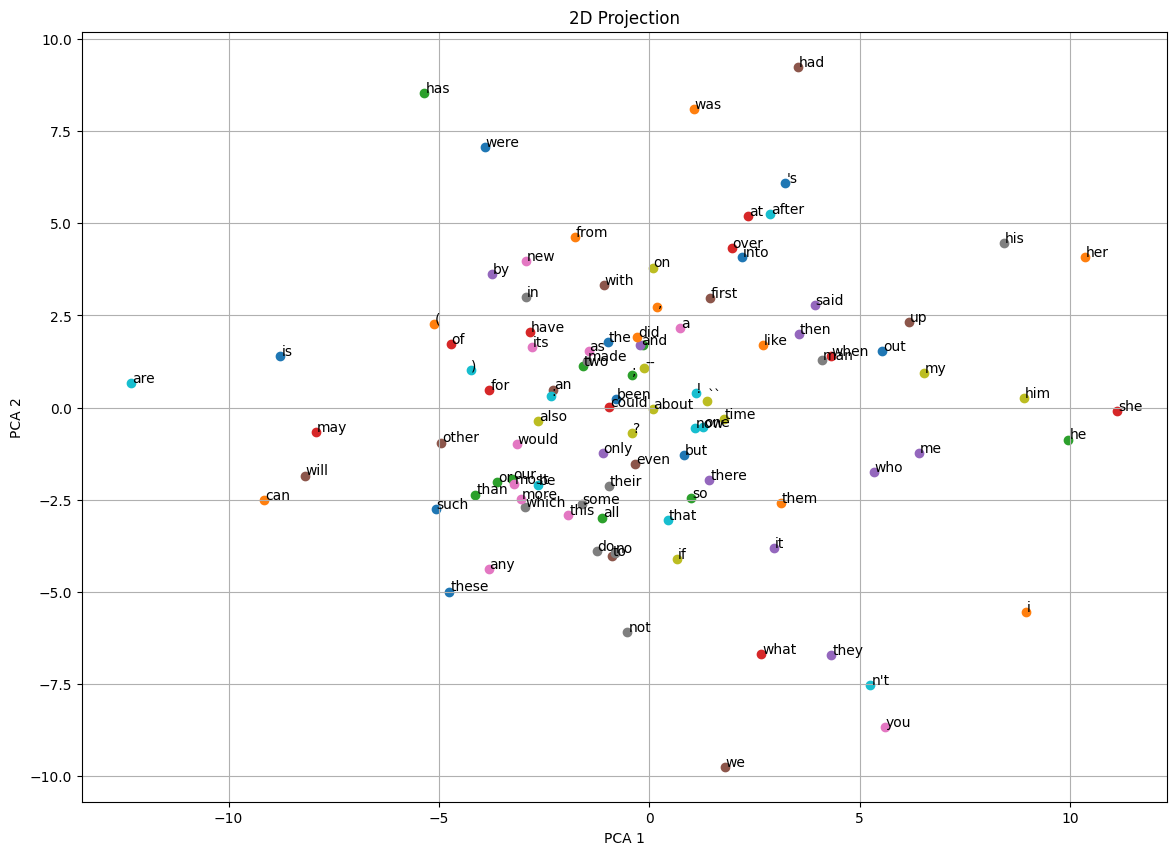

In [3]:
import nltk
from nltk.corpus import brown
from nltk import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

raw_text = ' '.join(brown.words())
raw_sentences = sent_tokenize(raw_text)
s = []
for raw in raw_sentences:
    words = word_tokenize(raw)
    l = []
    for word in words:
        l.append(word.lower())
    s.append(l)

def closest(v, m, e=None):    
    w = []
    embeddings = []
    for word in m.wv.key_to_index:
        if word not in e: 
            w.append(word)
            embeddings.append(m.wv[word])  

    embeddings = np.array(embeddings)
    cos_similarity = cosine_similarity([v], embeddings)[0]
    closest_word = np.argmax(cos_similarity)

    return w[closest_word], cos_similarity[closest_word]

model = Word2Vec(s, vector_size=300, window=8, min_count=5, workers=4)
new_vec = model.wv["queen"] - model.wv["female"] + model.wv["male"]
closest_word, similarity = closest(new_vec, model, e={"queen", "female", "male"})
print(f"Closest word to the given analogy: {closest_word} (Similarity: {similarity:.4f})")

king_analogy_sim = cosine_similarity([model.wv['king']], [new_vec])[0][0]
print(f"Cosine similarity between 'king' and the analogy: {king_analogy_sim:.4f}")



word_counts = Counter()
for x in s:
    for word in x:
        word_counts[word] += 1

common_words = []
for word, c in word_counts.most_common():
    if word in model.wv.key_to_index:
        common_words.append(word)
    if len(common_words) == 100:
        break

word_vectors = []
for word in common_words:
    word_vectors.append(model.wv[word])


pca = PCA(n_components=2)
array_2d = pca.fit_transform(word_vectors)

plt.figure(figsize=(14, 10))
for i in range(len(common_words)):
    x, y = array_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, common_words[i], fontsize=10)

plt.title("2D Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()




